In [8]:
import optuna
import pandas as pd
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [26]:
# === PATHS ===
SCRIPT_PATH = os.getcwd()
DATA_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'data', 'preprocessed', 'analysis_data'))
MODELS_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'models','XGBoost'))
FEATURES_NAMES_DIR = os.path.abspath(os.path.join(DATA_DIR,'feature_names.pkl'))
os.makedirs(MODELS_DIR, exist_ok=True)


# Load preprocessed data
train_data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
#val_data = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'))
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# Load feature names from saved file
feature_cols = joblib.load(FEATURES_NAMES_DIR)


In [17]:
le = LabelEncoder()
# Prepare features and labels
X_train = train_data[feature_cols]
y_train = train_data['Fault_Condition']
X_test = test_data[feature_cols]
y_test  = test_data['Fault_Condition']

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
# Global dictionary for optimization results
results = {}

In [18]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 4.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "multi:softprob",
        "num_class": len(np.unique(y_train_enc)),
        "eval_metric": "mlogloss",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train_enc, cv=cv, scoring="accuracy")

    return scores.mean()


In [19]:
start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
optuna_time = time.time() - start

print("\n==== OPTUNA RESULTS ====")
print("Best params:", study.best_params)
print("Best CV accuracy:", study.best_value)
print("Search time:", round(optuna_time, 2), "s")

[I 2025-11-24 19:17:16,505] A new study created in memory with name: no-name-a129ce6b-2c03-442f-aa5e-6caf2024d511
[I 2025-11-24 19:17:17,165] Trial 0 finished with value: 0.9138461538461538 and parameters: {'n_estimators': 404, 'max_depth': 6, 'learning_rate': 0.19313071946360758, 'subsample': 0.7756539758356705, 'colsample_bytree': 0.7068248815330628, 'gamma': 2.231660881379023, 'min_child_weight': 6}. Best is trial 0 with value: 0.9138461538461538.
[I 2025-11-24 19:17:17,578] Trial 1 finished with value: 0.9061538461538461 and parameters: {'n_estimators': 280, 'max_depth': 4, 'learning_rate': 0.19584359162969178, 'subsample': 0.8506368675000987, 'colsample_bytree': 0.6904478098794555, 'gamma': 0.9894737898314037, 'min_child_weight': 2}. Best is trial 0 with value: 0.9138461538461538.
[I 2025-11-24 19:17:18,061] Trial 2 finished with value: 0.9058461538461537 and parameters: {'n_estimators': 306, 'max_depth': 7, 'learning_rate': 0.14013307845667428, 'subsample': 0.9061566466382599, 'c


==== OPTUNA RESULTS ====
Best params: {'n_estimators': 203, 'max_depth': 9, 'learning_rate': 0.29942957567903994, 'subsample': 0.9262468810321873, 'colsample_bytree': 0.80912011424207, 'gamma': 3.963646729520301, 'min_child_weight': 4}
Best CV accuracy: 0.9295384615384614
Search time: 13.67 s


In [21]:
best_model = XGBClassifier(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train, y_train_enc)

y_pred_enc = best_model.predict(X_test)

# Odtwarzamy etykiety tekstowe
y_pred = le.inverse_transform(y_pred_enc)

print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred), 4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Test Accuracy: 0.9821

Classification Report:
              precision    recall  f1-score   support

      faulty       1.00      1.00      1.00        14
  faulty_zip       1.00      1.00      1.00        14
     healthy       1.00      0.93      0.96        14
 healthy_zip       0.93      1.00      0.97        14

    accuracy                           0.98        56
   macro avg       0.98      0.98      0.98        56
weighted avg       0.98      0.98      0.98        56



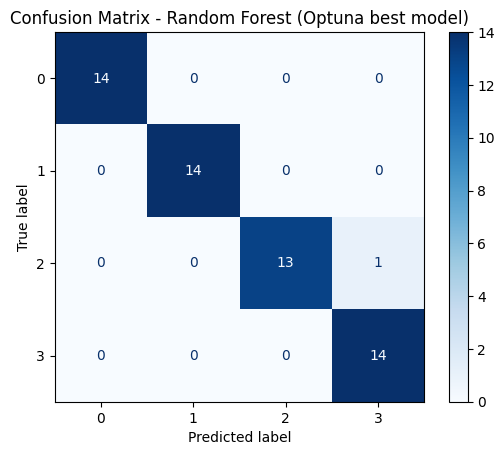

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Random Forest (Optuna best model)")
plt.show()

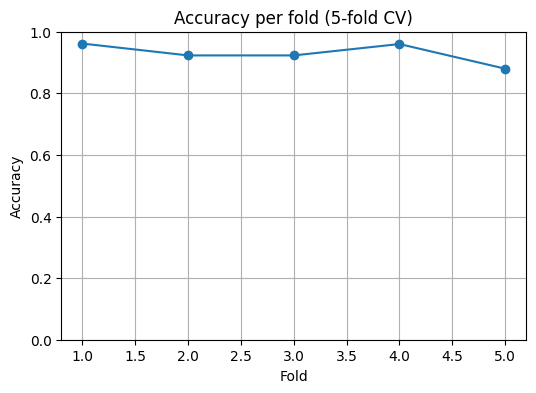

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = XGBClassifier(**study.best_params, random_state=42, n_jobs=-1)
fold_scores = cross_val_score(model, X_train, y_train_enc, cv=cv, scoring='accuracy')

plt.figure(figsize=(6,4))
plt.plot(range(1, 6), fold_scores, marker='o')
plt.title("Accuracy per fold (5-fold CV)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

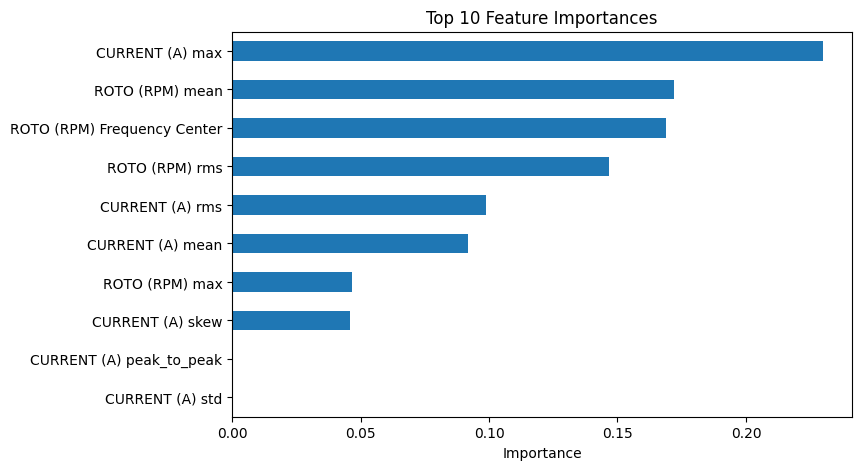

In [24]:
importances = pd.Series(best_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
importances.head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

In [27]:
# Save the trained model
MODEL_PATH = os.path.join(MODELS_DIR, 'XGBoost.pkl')
joblib.dump(best_model, MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")


Model saved to: C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models\XGBoost\XGBoost.pkl
